### Imports

In [1]:
from torch import nn
from torch import optim
from torch.nn import functional as F
from torchvision import transforms
from torchsummary import summary
from torch.utils.data import RandomSampler
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
import random
import torch
import torchvision

### Constants and definitions

In [2]:
%matplotlib inline

BATCH_SIZE = 128
COMPRESSED_DIMS = 2
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 20
LEARNING_RATE = 1e-3

### Load dataset

In [3]:
MNIST_train = torchvision.datasets.MNIST('../data/', 
                                         train = True, 
                                         download = True, 
                                         transform = transforms.Compose([transforms.ToTensor(),
                                                                         transforms.Normalize((0.1307,), (0.3081,))]))

MNIST_test = torchvision.datasets.MNIST('../data/', 
                                        train = False, 
                                        download = True,
                                        transform=transforms.Compose([transforms.ToTensor(),
                                                                      transforms.Normalize((0.1307,), (0.3081,))]))

In [4]:
MNIST_train

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [5]:
MNIST_test

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

### Create data loaders

In [6]:
train_loader = torch.utils.data.DataLoader(MNIST_train, batch_size = BATCH_SIZE, shuffle = True)

In [7]:
test_loader = torch.utils.data.DataLoader(MNIST_test, batch_size = 2 * BATCH_SIZE, shuffle = False)

### Encoder network

In [8]:
class MNIST_Encoder(nn.Module):
    def __init__(self):
        super(MNIST_Encoder, self).__init__()
        self.encode = nn.Sequential(
                        nn.Conv2d(1, 32, 3, 1),
                        nn.LeakyReLU(),
                        nn.Conv2d(32, 64, 3, 2),
                        nn.LeakyReLU(),
                        nn.Conv2d(64, 64, 3, 2),
                        nn.LeakyReLU(),
                        nn.Conv2d(64, 64, 3, 1),
                        nn.Flatten(),
                        nn.Linear(576, COMPRESSED_DIMS))

    def forward(self, x):
        return self.encode(x)

### Decoder network

In [9]:
class MNIST_Decoder(nn.Module):
    def __init__(self):
        super(MNIST_Decoder, self).__init__()
        self.lin = nn.Linear(COMPRESSED_DIMS, 3136)
        self.decode = nn.Sequential(
                        nn.ConvTranspose2d(64, 64, 3, padding=1),
                        nn.LeakyReLU(),
                        nn.ConvTranspose2d(64, 64, 3, stride=2, padding=1, output_padding=1),
                        nn.LeakyReLU(),
                        nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
                        nn.LeakyReLU(),
                        nn.ConvTranspose2d(32, 1, 3, padding=1),
                        nn.Sigmoid())
        
    def forward(self, x):
        x = self.lin(x)
        x = x.view(-1, 64, 7, 7)
        x = self.decode(x)
        
        return x

### Convolutional Autoencoder

In [10]:
class MNIST_Autoencoder(nn.Module):
    def __init__(self):
        super(MNIST_Autoencoder, self).__init__()
        self.encode = MNIST_Encoder()
        self.decode = MNIST_Decoder()
        
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        
        return x

### Training loop

Create model:

In [11]:
autoencoder = MNIST_Autoencoder()
autoencoder = autoencoder.to(DEVICE)

In [12]:
summary(autoencoder, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
         LeakyReLU-2           [-1, 32, 26, 26]               0
            Conv2d-3           [-1, 64, 12, 12]          18,496
         LeakyReLU-4           [-1, 64, 12, 12]               0
            Conv2d-5             [-1, 64, 5, 5]          36,928
         LeakyReLU-6             [-1, 64, 5, 5]               0
            Conv2d-7             [-1, 64, 3, 3]          36,928
           Flatten-8                  [-1, 576]               0
            Linear-9                    [-1, 2]           1,154
    MNIST_Encoder-10                    [-1, 2]               0
           Linear-11                 [-1, 3136]           9,408
  ConvTranspose2d-12             [-1, 64, 7, 7]          36,928
        LeakyReLU-13             [-1, 64, 7, 7]               0
  ConvTranspose2d-14           [-1, 64,

Define optimizer:

In [13]:
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3, weight_decay=1e-5)

Training loop:

In [14]:
def fit(epochs, model, loss, optimizer, data):
    
    # initialize info dict
    info = {
        'epoch': [],
        'loss': []
    }
        
    # for each epoch
    for epoch in range(epochs):
    
        # set the model to training mode
        model.train()
        
        # iterate through the dataset
        for x, _ in tqdm(data):
            
            # send data to GPU
            x = x.to(DEVICE)
            
            # infer and compute loss
            y_hat = model(x)
            loss_value = loss(y_hat, x)
            
            # update weights
            loss_value.backward()
            optimizer.step()
            optimizer.zero_grad()
                        
        # set model in inference mode
        model.eval()
        
        # without computing gradients
        with torch.no_grad():
            
            # compute validation loss
            validation_loss = 0
            for batch, _ in test_loader:
                x_val = batch.clone()
                x_val = x_val.to(DEVICE)
                y_val = model(batch.to(DEVICE))
                validation_loss += loss(y_val, x_val)            
        
        # update info
        validation_loss = validation_loss.item() / len(MNIST_train)
        info['epoch'].append(epoch + 1)
        info['loss'].append(validation_loss)
        
        # log
        print(f'End of epoch: {epoch + 1}\nValidation loss: {validation_loss}\n\n')
            
    # return training info
    return info

In [15]:
info = fit(EPOCHS, autoencoder, nn.MSELoss(), optimizer, train_loader)


End of epoch: 1
Validation loss: 0.00046093660990397135





End of epoch: 2
Validation loss: 0.000446238899230957





End of epoch: 3
Validation loss: 0.00043966073989868163





End of epoch: 4
Validation loss: 0.00043569491704305015





End of epoch: 5
Validation loss: 0.00043503440221150715





End of epoch: 6
Validation loss: 0.00043233283360799156





End of epoch: 7
Validation loss: 0.00043142611185709634





End of epoch: 8
Validation loss: 0.0004311950365702311





End of epoch: 9
Validation loss: 0.00043027044932047526





End of epoch: 10
Validation loss: 0.00042891407012939455





End of epoch: 11
Validation loss: 0.00042860488891601563





End of epoch: 12
Validation loss: 0.00042791512807210285





End of epoch: 13
Validation loss: 0.0004276355107625326





End of epoch: 14
Validation loss: 0.00042715409596761066





End of epoch: 15
Validation loss: 0.00042687501907348634





End of epoch: 16
Validation loss: 0.000427259349822998





End of epoch: 17
Validation loss: 0.00042646640141805013





End of epoch: 18
Validation loss: 0.00042580572764078776





End of epoch: 19
Validation loss: 0.0004263545354207357





End of epoch: 20
Validation loss: 0.00042610273361206057




In [16]:
def plot_training(losses):
    plt.plot(list(range(len(losses))), losses)

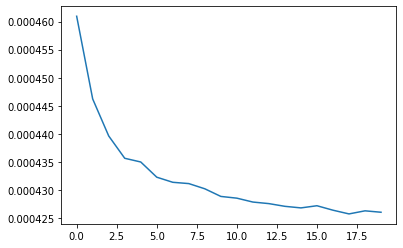

In [17]:
plot_training(info['loss'])

### Results

Reconstructing input images:

In [18]:
autoencoder.to('cpu')
autoencoder = autoencoder.eval()

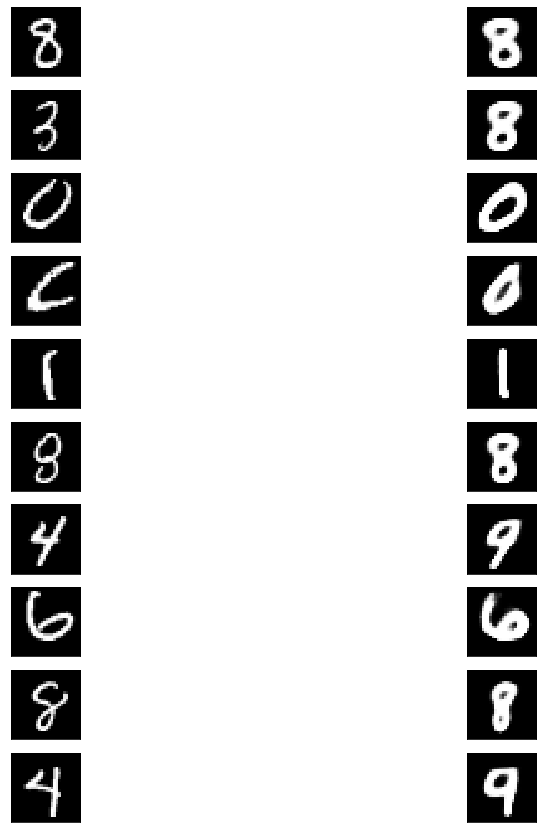

In [19]:
originals = []
generated = []

for _ in range(10):
    sample = random.randint(0, len(MNIST_test))
    original = MNIST_test[sample][0]
    x = original.unsqueeze(0)

    with torch.no_grad():
        y = autoencoder(x)

    originals.append(original.squeeze())
    generated.append(y.squeeze())

f, axes = plt.subplots(10, 
                       2,
                       figsize=(15,15),
                       sharex=True, 
                       sharey=True,
                       subplot_kw=dict(aspect='equal'))

for i in range(10):
    axes[i][0].imshow(originals[i], cmap='gray')
    axes[i][0].set_xticks([])
    axes[i][0].set_yticks([])
    axes[i][1].imshow(generated[i], cmap='gray')
    axes[i][1].set_xticks([])
    axes[i][1].set_yticks([])

Plot distribution:

In [20]:
# get encoder part of the autoencoder
encoder = autoencoder.encode
encoder.eval();

In [21]:
# setup empty encodings
encodings = {i : [] for i in range(10)}

# without computing gradients
with torch.no_grad():

    # get random batch from test set
    for test_images, test_labels in test_loader:
        
        # for each digit in the dataset
        for digit in range(10):

            # encode and store samples
            images = test_images[test_labels == digit]
            encoded = encoder(images)
            encodings[digit].extend([value.numpy() for value in encoded])

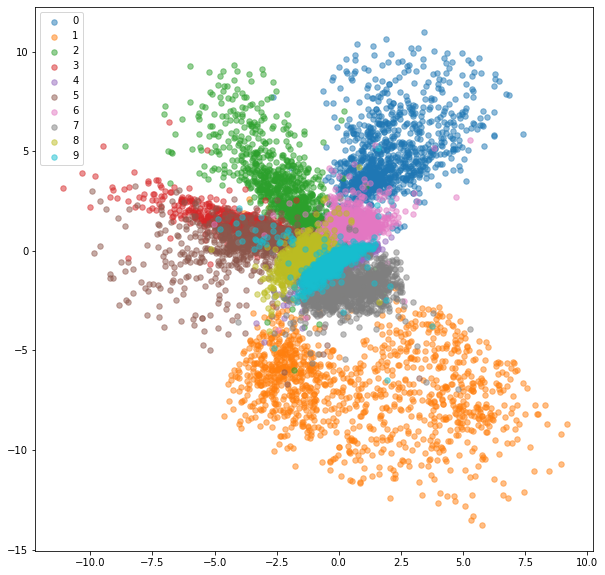

In [22]:
# plot distribution
fig = plt.figure(figsize=(10, 10))
axis = fig.add_subplot(1, 1, 1)
for digit in encodings.keys():
    xs = [x[0] for x in encodings[digit]]
    ys = [x[1] for x in encodings[digit]]
    axis.scatter(xs, ys, alpha=0.5, s=30, label=str(digit))
        
plt.legend(loc=2)
plt.show()

### Variational Autoencoder

Sampler layer:

In [23]:
class Sampler(nn.Module):
    def __init__(self):
        super(Sampler, self).__init__()
        
    def forward(self, mu, log_var):
        epsilon = torch.randn_like(mu)
        return mu + torch.exp(log_var / 2) * epsilon 

Variational encoder:

In [24]:
class MNIST_VAE_Encoder(nn.Module):
    def __init__(self):
        super(MNIST_VAE_Encoder, self).__init__()
        self.encode = nn.Sequential(
                        nn.Conv2d(1, 32, 3, 1),
                        nn.LeakyReLU(),
                        nn.Conv2d(32, 64, 3, 2),
                        nn.LeakyReLU(),
                        nn.Conv2d(64, 64, 3, 2),
                        nn.LeakyReLU(),
                        nn.Conv2d(64, 64, 3, 1),
                        nn.LeakyReLU(),
                        nn.Flatten())
        self.mu = nn.Linear(576, COMPRESSED_DIMS)
        self.log_var = nn.Linear(576, COMPRESSED_DIMS)
        self.sample = Sampler()

    def forward(self, x):
        x = self.encode(x)
        mu = self.mu(x)
        log_var = self.log_var(x)
        sampled = self.sample(mu, log_var)
        
        return [mu, log_var, sampled]

Combine encoder and variational decoder:

In [25]:
class MNIST_VAE(nn.Module):
    def __init__(self):
        super(MNIST_VAE, self).__init__()
        self.encode = MNIST_VAE_Encoder()
        self.decode = MNIST_Decoder()
        
    def forward(self, x):
        mu, log_var, x = self.encode(x)
        x = self.decode(x)
        return mu, log_var, x

In [26]:
vae = MNIST_VAE()
vae.to(DEVICE);

In [27]:
summary(vae, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
         LeakyReLU-2           [-1, 32, 26, 26]               0
            Conv2d-3           [-1, 64, 12, 12]          18,496
         LeakyReLU-4           [-1, 64, 12, 12]               0
            Conv2d-5             [-1, 64, 5, 5]          36,928
         LeakyReLU-6             [-1, 64, 5, 5]               0
            Conv2d-7             [-1, 64, 3, 3]          36,928
         LeakyReLU-8             [-1, 64, 3, 3]               0
           Flatten-9                  [-1, 576]               0
           Linear-10                    [-1, 2]           1,154
           Linear-11                    [-1, 2]           1,154
          Sampler-12                    [-1, 2]               0
MNIST_VAE_Encoder-13  [[-1, 2], [-1, 2], [-1, 2]]               0
           Linear-14                 

### Improved loss

Kullback–Leibler (KL) divergence:

In [28]:
def KLDivergenceLoss(mu, log_var):
    return -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

Compose VAE loss by reconstruction MSE loss (reduced by sum) and KL divergence:

In [29]:
def VAELoss(y_hat, y, mu, log_var):
    return F.mse_loss(y_hat, y, reduction='sum') + KLDivergenceLoss(mu, log_var)

### Training loop

Create optimizer:

In [30]:
optimizer = optim.Adam(vae.parameters(), lr=LEARNING_RATE)

Vae training loop:

In [31]:
def fit_vae(epochs, model, loss, optimizer, data):
    
    # initialize info dict
    info = {
        'epoch': [],
        'loss': []
    }
        
    # for each epoch
    for epoch in range(epochs):
    
        # set the model to training mode
        model.train()
        
        # iterate through the dataset
        for x, _ in tqdm(data):
            
            # send data to GPU
            x = x.to(DEVICE)
            
            # infer and compute loss
            mu, log_var, y_hat = model(x)
            loss_value = loss(y_hat, x, mu, log_var)
            
            # update weights
            loss_value.backward()
            optimizer.step()
            optimizer.zero_grad()
                        
        # set model in inference mode
        model.eval()
        
        # without computing gradients
        with torch.no_grad():
            
            # compute validation loss
            validation_loss = 0
            for batch, _ in test_loader:
                y_val = batch.clone()
                y_val = y_val.to(DEVICE)
                mu, log_var, y_hat_val = model(batch.to(DEVICE))
                validation_loss += loss(y_hat_val, y_val, mu, log_var)            
        
        # update info
        validation_loss = validation_loss.item() / len(MNIST_train)
        info['epoch'].append(epoch + 1)
        info['loss'].append(validation_loss)
        
        # log
        print(f'End of epoch: {epoch + 1}\nValidation loss: {validation_loss}\n\n')
            
    # return training info
    return info

In [32]:
info = fit_vae(EPOCHS, vae, VAELoss, optimizer, train_loader)


End of epoch: 1
Validation loss: 89.41040833333334





End of epoch: 2
Validation loss: 87.11065





End of epoch: 3
Validation loss: 86.123275





End of epoch: 4
Validation loss: 85.6034





End of epoch: 5
Validation loss: 85.18003333333333





End of epoch: 6
Validation loss: 84.934425





End of epoch: 7
Validation loss: 84.780725





End of epoch: 8
Validation loss: 84.59225





End of epoch: 9
Validation loss: 84.42871666666667





End of epoch: 10
Validation loss: 84.30335





End of epoch: 11
Validation loss: 84.12603333333334





End of epoch: 12
Validation loss: 84.31041666666667





End of epoch: 13
Validation loss: 84.017225





End of epoch: 14
Validation loss: 83.95643333333334





End of epoch: 15
Validation loss: 84.101075





End of epoch: 16
Validation loss: 83.9687





End of epoch: 17
Validation loss: 83.79170833333333





End of epoch: 18
Validation loss: 83.67445833333333





End of epoch: 19
Validation loss: 83.68489166666667





End of epoch: 20
Validation loss: 83.7289




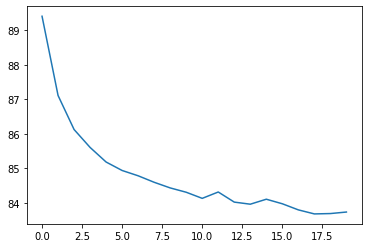

In [33]:
plot_training(info['loss'])

### Results

Image reconstruction:

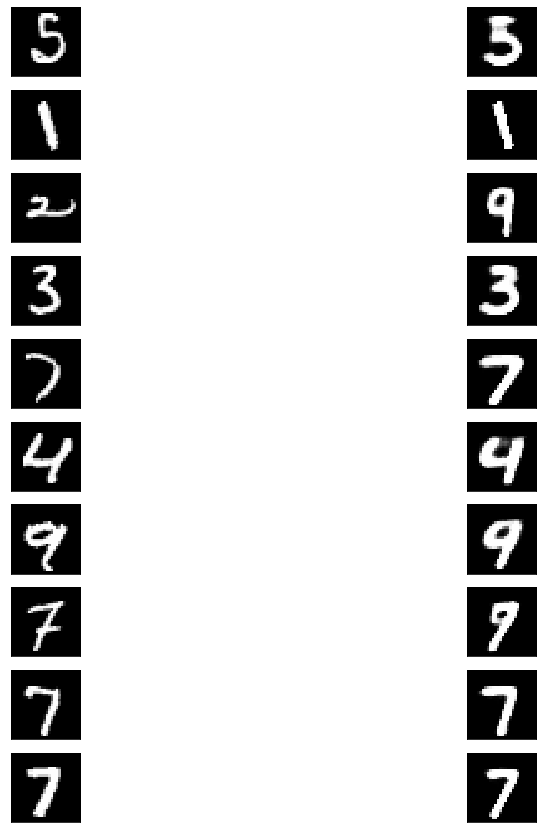

In [34]:
originals = []
generated = []

for _ in range(10):
    sample = random.randint(0, len(MNIST_test))
    original = MNIST_test[sample][0]
    x = original.unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        mu, log_var, y = vae(x)

    originals.append(original.squeeze())
    generated.append(y.squeeze())

f, axes = plt.subplots(10, 
                       2,
                       figsize=(15,15),
                       sharex=True, 
                       sharey=True,
                       subplot_kw=dict(aspect='equal'))

for i in range(10):
    axes[i][0].imshow(originals[i].to('cpu').numpy(), cmap='gray')
    axes[i][0].set_xticks([])
    axes[i][0].set_yticks([])
    axes[i][1].imshow(generated[i].to('cpu').numpy(), cmap='gray')
    axes[i][1].set_xticks([])
    axes[i][1].set_yticks([])

Plot distribution:

In [35]:
encoder = vae.encode.to('cpu')

In [36]:
# setup empty encodings
encodings = {i : [] for i in range(10)}

# without computing gradients
with torch.no_grad():

    # get random batch from test set
    for test_images, test_labels in test_loader:
        for digit in range(10):
            images = test_images[test_labels == digit]
            _, _, encoded = encoder(images)
            encodings[digit].extend([representation.numpy() for representation in encoded])

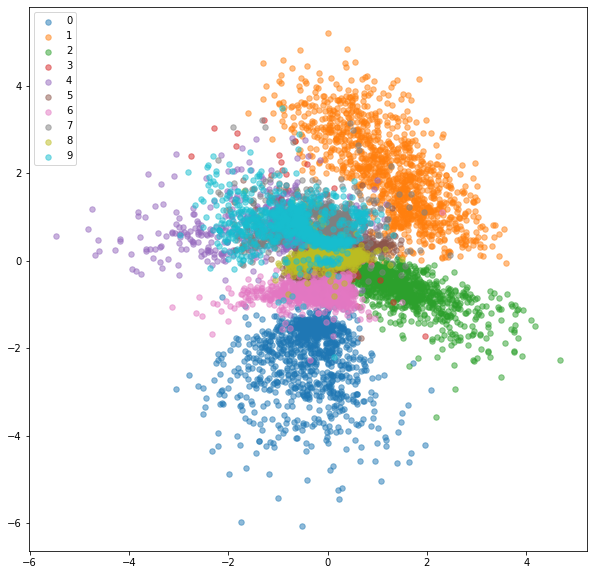

In [37]:
# plot distribution
fig = plt.figure(figsize=(10, 10))
axis = fig.add_subplot(1, 1, 1)
for digit in encodings.keys():
    xs = [x[0] for x in encodings[digit]]
    ys = [x[1] for x in encodings[digit]]
    axis.scatter(xs, ys, alpha=0.5, s=30, label=str(digit))
        
plt.legend(loc=2)
plt.show()